--- paso 1: adquisicion ---
descomprimiendo...
total imagenes encontradas: 1907

visualizando una muestra de cada clase (originales)...


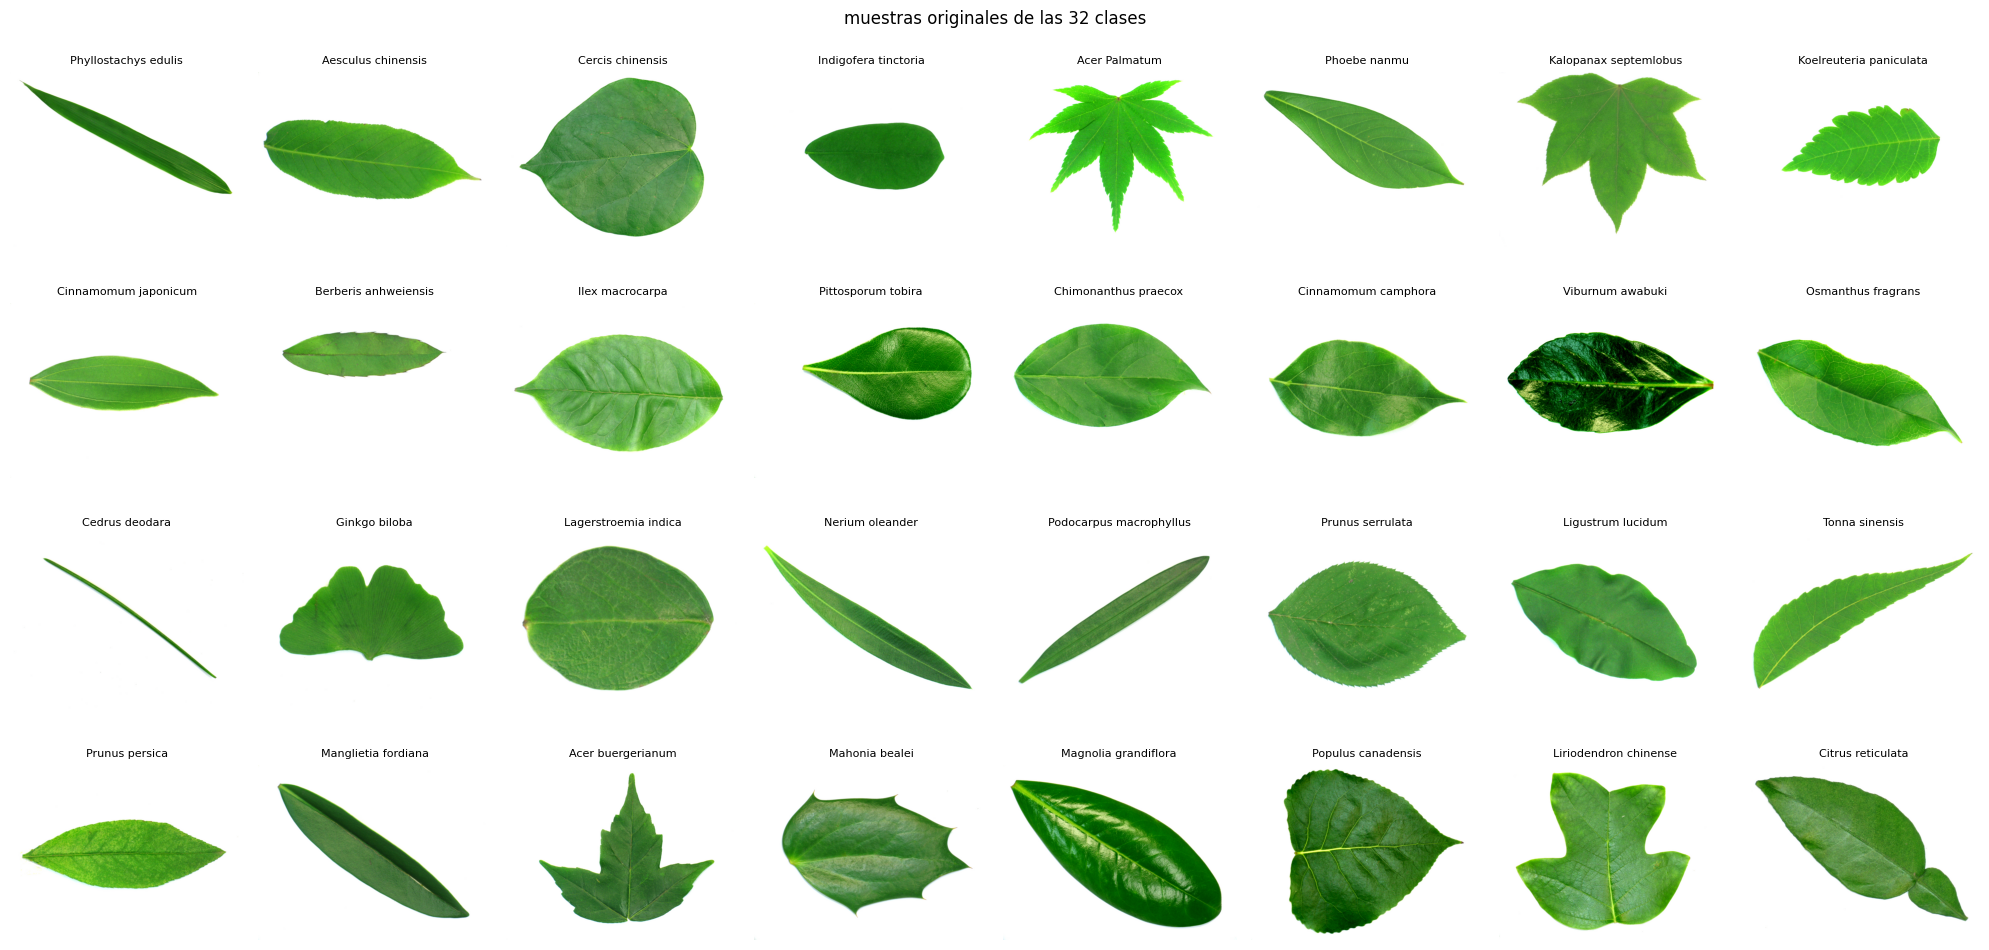

In [ ]:
# importacion de librerias
import os
import urllib.request
import tarfile
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# definicion del mapeo de clases segun tu informacion
# formato: (inicio, fin, nombre_cientifico)
mapa_clases = [
    (1001, 1059, "Phyllostachys edulis"),
    (1060, 1122, "Aesculus chinensis"),
    (1123, 1194, "Cercis chinensis"),
    (1195, 1267, "Indigofera tinctoria"),
    (1268, 1323, "Acer Palmatum"),
    (1324, 1385, "Phoebe nanmu"),
    (1386, 1437, "Kalopanax septemlobus"),
    (1438, 1496, "Koelreuteria paniculata"),
    (1497, 1551, "Cinnamomum japonicum"),
    (1552, 1616, "Berberis anhweiensis"),
    (2001, 2050, "Ilex macrocarpa"),
    (2051, 2113, "Pittosporum tobira"),
    (2114, 2165, "Chimonanthus praecox"),
    (2166, 2230, "Cinnamomum camphora"),
    (2231, 2290, "Viburnum awabuki"),
    (2291, 2346, "Osmanthus fragrans"),
    (2347, 2423, "Cedrus deodara"),
    (2424, 2485, "Ginkgo biloba"),
    (2486, 2546, "Lagerstroemia indica"),
    (2547, 2612, "Nerium oleander"),
    (2616, 2675, "Podocarpus macrophyllus"),
    (3001, 3055, "Prunus serrulata"),
    (3056, 3110, "Ligustrum lucidum"),
    (3111, 3175, "Tonna sinensis"),
    (3176, 3229, "Prunus persica"),
    (3230, 3281, "Manglietia fordiana"),
    (3282, 3334, "Acer buergerianum"),
    (3335, 3389, "Mahonia bealei"),
    (3390, 3446, "Magnolia grandiflora"),
    (3447, 3510, "Populus canadensis"),
    (3511, 3563, "Liriodendron chinense"),
    (3566, 3621, "Citrus reticulata")
]

# funcion auxiliar para obtener el nombre de la clase dado el archivo
def obtener_clase(nombre_archivo):
    try:
        numero = int(os.path.splitext(nombre_archivo)[0])
        for inicio, fin, nombre in mapa_clases:
            if inicio <= numero <= fin:
                return nombre
    except:
        return None
    return None

# paso 1: adquisicion de la imagen
print("--- paso 1: adquisicion ---")
url = "https://sourceforge.net/projects/flavia/files/Leaf%20Image%20Dataset/1.0/Leaves.tar.bz2/download"
archivo_tar = "Leaves.tar.bz2"

# descargar si no existe
if not os.path.exists(archivo_tar):
    print("descargando dataset flavia...")
    urllib.request.urlretrieve(url, archivo_tar)

# descomprimir
print("descomprimiendo...")
with tarfile.open(archivo_tar, "r:bz2") as tar:
    tar.extractall("./")

ruta_base = "./Leaves"
todos_archivos = sorted(glob.glob(os.path.join(ruta_base, "*.jpg")))
print(f"total imagenes encontradas: {len(todos_archivos)}")

# visualizacion inicial: una imagen de cada clase
print("\nvisualizando una muestra de cada clase (originales)...")
muestras = {}
for archivo in todos_archivos:
    nombre = os.path.basename(archivo)
    clase = obtener_clase(nombre)
    if clase and clase not in muestras:
        muestras[clase] = archivo
    if len(muestras) == 32: break

plt.figure(figsize=(20, 10))
i = 1
for clase, ruta in muestras.items():
    img = cv2.imread(ruta)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 8, i)
    plt.imshow(img)
    plt.title(clase, fontsize=8)
    plt.axis('off')
    i += 1
plt.suptitle("muestras originales de las 32 clases")
plt.tight_layout()
plt.show()


--- paso 2: demostracion de preprocesamiento ---


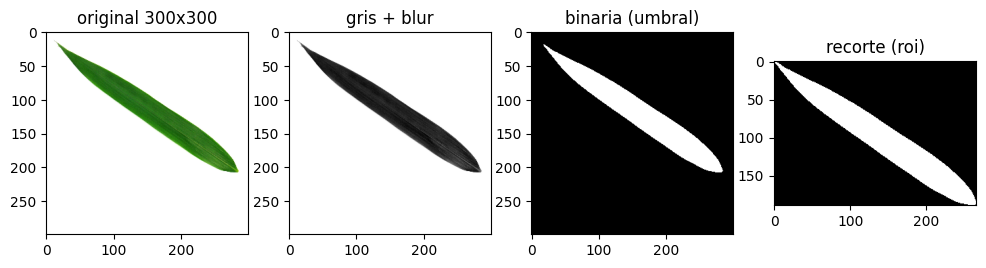

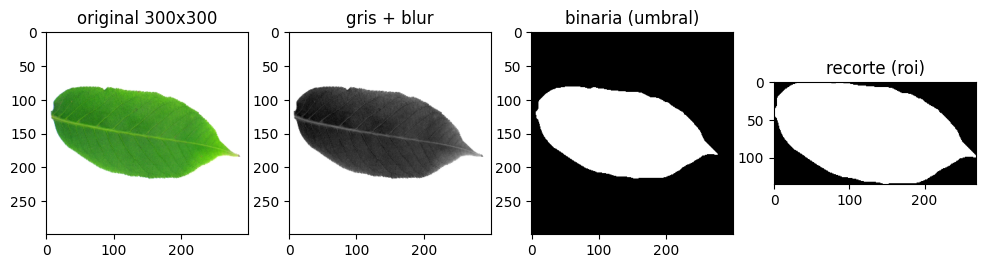

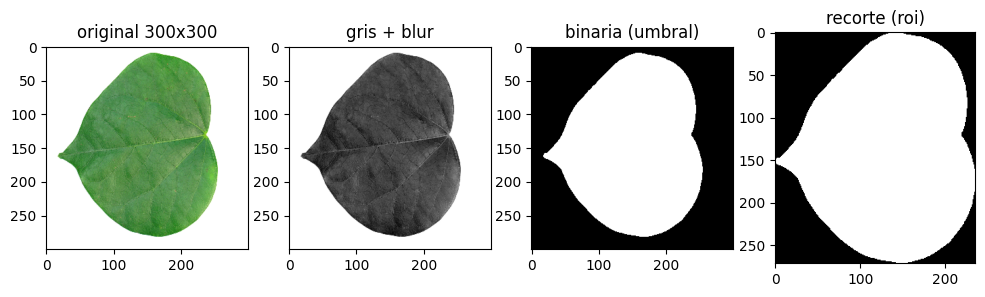

In [ ]:
# paso 2: preprocesamiento
# funcion que aplica los pasos: resize, gray, blur, threshold, crop
def procesar_imagen(ruta, visualizar=False):
    # lectura
    img = cv2.imread(ruta)
    if img is None: return None, None

    # reducir tamaño a 300x300
    img = cv2.resize(img, (300, 300))
    original = img.copy()

    # escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # suavizado gaussiano
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # binarizacion (otsu) + inversion
    # recortar pixeles negros. opencv usa blancos para contornos.
    # invertimos para que la hoja sea blanca y el fondo negro para el calculo
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # morfologia para cerrar huecos (mejora la calidad de momentos hu)
    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # encontrar contornos y recortar (roi)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours: return None, None

    # contorno maximo es la hoja
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)

    # recorte de la imagen binaria (roi)
    roi = thresh[y:y+h, x:x+w]

    # visualizacion del paso a paso
    if visualizar:
        plt.figure(figsize=(12, 3))
        plt.subplot(1, 4, 1); plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)); plt.title("original 300x300")
        plt.subplot(1, 4, 2); plt.imshow(gray, cmap='gray'); plt.title("gris + blur")
        plt.subplot(1, 4, 3); plt.imshow(thresh, cmap='gray'); plt.title("binaria (umbral)")
        plt.subplot(1, 4, 4); plt.imshow(roi, cmap='gray'); plt.title("recorte (roi)")
        plt.show()

    return roi, cnt

# visualizacion del preprocesamiento en 3 ejemplos
print("\n--- paso 2: demostracion de preprocesamiento ---")
ejemplos_visuales = list(muestras.values())[:3] # tomamos 3 ejemplos
for ruta in ejemplos_visuales:
    procesar_imagen(ruta, visualizar=True)

In [ ]:
# paso 3: extraccion de caracteristicas
def extraer_features(roi, cnt):
    features = []

    # area (a)
    area = cv2.contourArea(cnt)

    # perimetro (p)
    perimetro = cv2.arcLength(cnt, True)
    if perimetro == 0: perimetro = 1.0

    # bounding box
    x, y, w, h = cv2.boundingRect(cnt)

    # ejes mayor y menor
    if len(cnt) >= 5:
        (xe, ye), (eje_menor, eje_mayor), angulo = cv2.fitEllipse(cnt)
    else:
        eje_mayor, eje_menor = h, w

    # relacion de aspecto (ancho/alto)
    aspect_ratio = float(w)/h if h!=0 else 0

    # factor de forma: 4*pi*a / p^2
    form_factor = (4 * np.pi * area) / (perimetro**2)

    # rectangularidad: (ancho*largo) / a (segun documento)
    rect_area = w * h
    rectangularity = rect_area / area if area > 0 else 0

    # relacion perimetro / diametro (ancho)
    p_w_ratio = perimetro / w if w > 0 else 0

    features.extend([area, perimetro, eje_mayor, eje_menor, aspect_ratio, form_factor, rectangularity, p_w_ratio])

    # momentos de hu (sobre la silueta)
    moments = cv2.moments(roi)
    hu = cv2.HuMoments(moments)

    # logaritmo para escalar momentos hu
    for i in range(7):
        val = hu[i][0]
        if val != 0:
            features.append(-1 * np.copysign(1.0, val) * np.log10(abs(val)))
        else:
            features.append(0)

    return features

# procesar todo el dataset
print("\n--- procesando todas las imagenes y generando dataset ---")
datos = []
etiquetas = []

for ruta in todos_archivos:
    nombre_archivo = os.path.basename(ruta)
    nombre_clase = obtener_clase(nombre_archivo)

    if nombre_clase:
        try:
            roi, cnt = procesar_imagen(ruta, visualizar=False)
            if roi is not None and cnt is not None:
                feats = extraer_features(roi, cnt)
                datos.append(feats)
                etiquetas.append(nombre_clase)
        except Exception as e:
            pass

# crear dataframe
cols = ['area', 'perimetro', 'eje_mayor', 'eje_menor', 'aspect_ratio',
        'factor_forma', 'rectangularidad', 'ratio_p_ancho']
cols += [f'hu_{i+1}' for i in range(7)]

df = pd.DataFrame(datos, columns=cols)
df['clase'] = etiquetas

print(f"dataset finalizado. muestras: {len(df)}. clases: {df['clase'].nunique()}")


--- procesando todas las imagenes y generando dataset ---
dataset finalizado. muestras: 1907. clases: 32


In [ ]:
# paso 4: clasificacion
print("\n--- paso 4: entrenamiento y clasificacion ---")

X = df.drop('clase', axis=1)
y = df['clase']

# escalado de datos (importante para svm y mlp)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# division train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# modelo svm (kernel rbf para mejor ajuste)
svm = SVC(kernel='rbf', C=100, gamma='scale', probability=True)
svm.fit(X_train, y_train)
acc_svm = svm.score(X_test, y_test)

# modelo knn (ponderado por distancia)
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train, y_train)
acc_knn = knn.score(X_test, y_test)

# modelo mlp (red neuronal)
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=2000, learning_rate='adaptive', random_state=42)
mlp.fit(X_train, y_train)
acc_mlp = mlp.score(X_test, y_test)

print("-" * 30)
print("metricas de precision (accuracy):")
print(f"svm: {acc_svm:.2%}")
print(f"knn: {acc_knn:.2%}")
print(f"mlp: {acc_mlp:.2%}")
print("-" * 30)

# guardar
joblib.dump(svm, 'modelo_svm_final.pkl')
joblib.dump(scaler, 'scaler_final.pkl')
print("modelos guardados.")


--- paso 4: entrenamiento y clasificacion ---
------------------------------
metricas de precision (accuracy):
svm: 80.89%
knn: 72.77%
mlp: 80.89%
------------------------------
modelos guardados.
